In [195]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [196]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [197]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

In [198]:
df_settle = pd.read_csv(Path("yen.csv"))

In [199]:
df_settle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10902 entries, 0 to 10901
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        10902 non-null  object 
 1   Open                        10902 non-null  float64
 2   High                        10902 non-null  float64
 3   Low                         10902 non-null  float64
 4   Last                        10902 non-null  float64
 5   Change                      1415 non-null   float64
 6   Settle                      10902 non-null  float64
 7   Volume                      10902 non-null  float64
 8   Previous Day Open Interest  10902 non-null  float64
dtypes: float64(8), object(1)
memory usage: 766.7+ KB


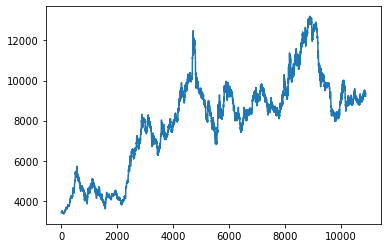

In [200]:
# Plot just the "Settle" column from the dataframe:
df_settle["Settle"].plot()

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [201]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
settle_noise, settle_trend = sm.tsa.filters.hpfilter(df_settle["Settle"])


In [202]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
df_settle = df_settle.groupby("Date").sum()
df_sttl1 = df_settle
df_sttl1 = df_sttl1.drop(columns=["Open", "High", "Low", "Change", "Last", "Volume", "Previous Day Open Interest"])
df_sttl1.head()

,Settle
Date,
1976-08-02,3401.0
1976-08-03,3401.0
1976-08-04,3401.0
1976-08-05,3401.0
1976-08-06,3401.0


In [203]:
df_sttl2 = df_sttl1 + sm.tsa.filters.hpfilter(df_settle["Settle"])
df_sttl2

ValueError: Unable to coerce to Series, length must be 1: given 2

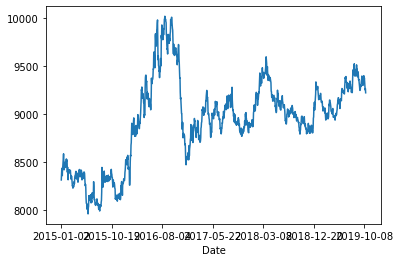

In [194]:
# Plot the Settle Price vs. the Trend for 2015 to the present

df_sttl1.loc["2015": "2021"].Settle.plot()


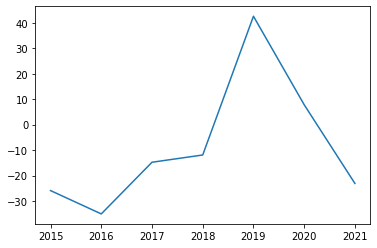

In [192]:
# Plot the Settle Noise
settle_noise.loc["2015": "2021"].plot()

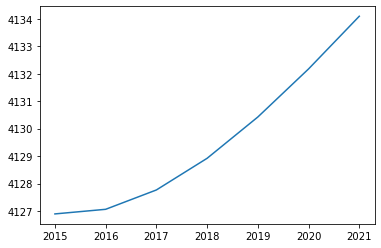

In [193]:

settle_trend.loc["2015": "2021"].plot()

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [150]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [152]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.Settle.values, order=(2, 1))

# Fit the model and assign it to a variable called results
results = model.fit()

In [156]:
# Output model summary results:
results.forecast(steps=2)

(array([0.0122944 , 0.00543701]),
 array([0.69187027, 0.69191656]),
 array([[-1.34374642,  1.36833522],
        [-1.35069453,  1.36156855]]))

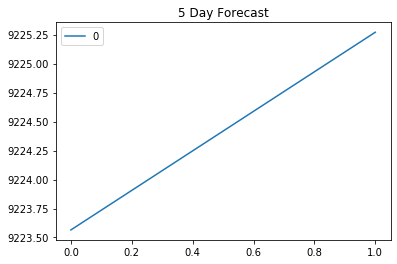

In [183]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=2)[0]).plot(title="5 Day Forecast")


In [158]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Mon, 24 May 2021   AIC                          15798.142
Time:                        15:17:22   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.421      -0.009       0.022
ar.L1.y       -0.3064      1.277     -0.240      0.810      -2.810       2.197
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2949      1.277      0.231      0.817      -2.208       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3326           +0.0000j            3.3326            0.5000
AR.2         -157.0960           +0.0000j          157.0960            0.5000
MA.1           -3.3914           +0.0000j            3.3914            0.5000
-----------------------------------------------------------------------------
"""

In [160]:
#AIC and BIC numbers are close



---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [204]:
from statsmodels.tsa.arima_model import ARIMA
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
df_settle = pd.read_csv(Path("yen.csv"))

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))

# Fit the model


In [205]:
model = ARIMA(df_settle["Settle"], order = (5, 1, 1))

In [206]:
results = model.fit()

In [207]:
results.forecast(steps=3)

(array([9223.56533019, 9225.27062153, 9226.28396703]),
 array([57.38520152, 80.73246332, 98.54069185]),
 array([[9111.09240196, 9336.03825841],
        [9067.03790104, 9383.50334202],
        [9033.14775998, 9419.42017408]]))

In [208]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                10901
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -59614.572
Method:                       css-mle   S.D. of innovations             57.385
Date:                Mon, 24 May 2021   AIC                         119245.144
Time:                        17:48:23   BIC                         119303.517
Sample:                             1   HQIC                        119264.818
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5346      0.526      1.017      0.309      -0.496       1.565
ar.L1.D.Settle     0.2260      0.595      0.380      0.704      -0.940       1.392
ar.L2.D.Settle    -0.0026      0.012     -0.223      0.824      -0.025       0.020
ar.L3.D.Settle    -0.0061      0.010     -0.594      0.552      -0.026       0.014
ar.L4.D.Settle    -0.0133      0.011     -1.244      0.214      -0.034       0.008
ar.L5.D.Settle    -0.0024      0.014     -0.178      0.859      -0.029       0.024
ma.L1.D.Settle    -0.2365      0.595     -0.397      0.691      -1.403       0.930
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9131           -1.4191j            2.3820           -0.1016
AR.2            1.9131           +1.4191j            2.3820            0.1016
AR.3           -1.7096           -3.0616j            3.5066           -0.3311
AR.4           -1.7096           +3.0616j            3.5066            0.3311
AR.5           -5.8738           -0.0000j            5.8738           -0.5000
MA.1            4.2288           +0.0000j            4.2288            0.0000
-----------------------------------------------------------------------------
"""

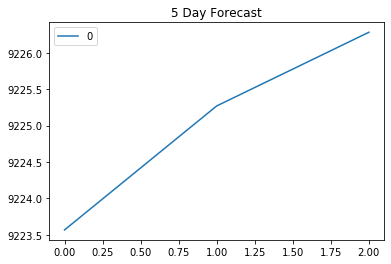

In [209]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=3)[0]).plot(title="5 Day Forecast")


---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [218]:
from arch import arch_model

In [219]:
# Estimate a GARCH model:
g_model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
res = g_model.fit(disp="off")

In [220]:
# Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Mon, May 24 2021   Df Residuals:                     7514
Time:                        18:01:26   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [221]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [223]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecast_5day = res.forecast(start="2019-10-15", horizon=forecast_horizon)
forecast_5day

In [224]:
# Annualize the forecast
intermediate = np.sqrt(forecast_5day.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434048,7.475745,7.516867,7.557426,7.597434


In [225]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434048
h.2,7.475745
h.3,7.516867
h.4,7.557426
h.5,7.597434


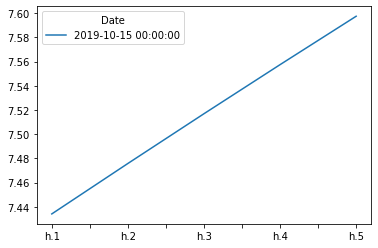

In [226]:
# Plot the final forecast
final.plot()

---

# Conclusions

Based on your time series analysis, would you buy the yen now?  

Yes. What I recall is that the BIC (versus the AIC) is the more important of the two. The BIC searches for the best model from the data provided, while the AIC attempts to measure the best unknown model. Because both numbers are within 5% of each other, so that tells me there isn't much volatility. 

Is the risk of the yen expected to increase or decrease?
Since GARCH is used to show the clusters of volatility, I see that the model, expressed via the plot, has a positive correlation. The risk is expected to decrease. 

Based on the model evaluation, would you feel confident in using these models for trading? 
I would like to feel confident in these models, but I have struggled a lot with these formulas, so it is about my confidence in understanding these models, and my confidence is a bit shaky!